# Allatom models

Parameters:

* $c$ -- cutoff
* $b$ -- number of bins for each pair of atom types
* $r$ -- topological distance to skipping neighbouring atoms

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
mat_file_patterns = []

for num_bins in [7, 10, 15, 20, 25, 30, 35, 40]:
    for cutoff in [5, 6, 7]:
        for radius in [0, 1, 2]:
            mat_file_patterns.append('*allatom-s0-b{}-c{}-r{}--skip_errors.mat'.format(num_bins, cutoff, radius))

In [3]:
checksums = ['58de9109da959d5b94380e3eaca552c1']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Logistic",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("MaxAbsScaler + Logistic",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [6]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[0], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [7]:
results_train = {}
results_val = {}

In [8]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [11]:
pool = Pool(processes=15)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

In [12]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Done


(0, 0)

## Test

In [13]:
params = ['b', 'c', 'r']

In [14]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    df = pd.concat([x[2] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = generate_benchmark(results, quality_criterion)
    plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    display(results[benchmark[model].argmax()][model])

In [15]:
df = summary(results_val)
display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean rank of the native  \
MaxAbsScaler + Logistic + native + mean_top1_score                 5.14159   
MaxAbsScaler + Ridge + native + mean_top1_score                     18.323   
Normalizer + Logistic + native + mean_top1_score                   4.62832   
Normalizer + Ridge + native + mean_top1_score                      10.5442   
MaxAbsScaler + Logistic + native + correlation_...                 7.25664   
MaxAbsScaler + Ridge + native + correlation_score                  17.0531   
Normalizer + Logistic + native + correlation_score                 5.42035   
Normalizer + Ridge + native + correlation_score                    25.9336   

                                                       Top 1     Top 5  \
MaxAbsScaler + Logistic + native + mean_top1_score  0.774336  0.884956   
MaxAbsScaler + Ridge + native + mean_top1_score     0.442478  0.637168   
Normalizer + Logistic + native + mean_top1_score    0.747788  0.853982   
Normalizer + Ridge + native + mean_top1_score       0.548673  0.668142   
MaxAbsScaler + Logistic + native + correlation_...  0.646018   0.80531   
MaxAbsScaler + Ridge + native + correlation_score   0.415929  0.646018   
Normalizer + Logistic + native + correlation_score   0.70354  0.840708   
Normalizer + Ridge + native + correlation_score     0.132743  0.331858   

                                                   Mean score for top 1  \
MaxAbsScaler + Logistic + native + mean_top1_score             0.902229   
MaxAbsScaler + Ridge + native + mean_top1_score                0.776832   
Normalizer + Logistic + native + mean_top1_score               0.894609   
Normalizer + Ridge + native + mean_top1_score                  0.803394   
MaxAbsScaler + Logistic + native + correlation_...             0.840761   
MaxAbsScaler + Ridge + native + correlation_score               0.75751   
Normalizer + Logistic + native + correlation_score             0.867485   
Normalizer + Ridge + native + correlation_score                0.565536   

                                                   Mean loss score  \
MaxAbsScaler + Logistic + native + mean_top1_score       0.0977712   
MaxAbsScaler + Ridge + native + mean_top1_score           0.223168   
Normalizer + Logistic + native + mean_top1_score          0.105391   
Normalizer + Ridge + native + mean_top1_score             0.196606   
MaxAbsScaler + Logistic + native + correlation_...        0.159239   
MaxAbsScaler + Ridge + native + correlation_score          0.24249   
Normalizer + Logistic + native + correlation_score        0.132515   
Normalizer + Ridge + native + correlation_score           0.434464   

                                                   Mean Pearson Mean Spearman  \
MaxAbsScaler + Logistic + native + mean_top1_score    -0.160959    -0.0664942   
MaxAbsScaler + Ridge + native + mean_top1_score       -0.536199     -0.453984   
Normalizer + Logistic + native + mean_top1_score       -0.29805     -0.197296   
Normalizer + Ridge + native + mean_top1_score          -0.35506     -0.295694   
MaxAbsScaler + Logistic + native + correlation_...    -0.209533     -0.128697   
MaxAbsScaler + Ridge + native + correlation_score     -0.570682     -0.480529   
Normalizer + Logistic + native + correlation_score    -0.354697     -0.265234   
Normalizer + Ridge + native + correlation_score       -0.500791     -0.419993   

                                                                          The best dataset  
MaxAbsScaler + Logistic + native + mean_top1_score  *allatom-s0-b40-c7-r1--skip_errors.mat  
MaxAbsScaler + Ridge + native + mean_top1_score     *allatom-s0-b20-c5-r1--skip_errors.mat  
Normalizer + Logistic + native + mean_top1_score    *allatom-s0-b35-c5-r1--skip_errors.mat  
Normalizer + Ridge + native + mean_top1_score        *allatom-s0-b7-c5-r1--skip_errors.mat  
MaxAbsScaler + Logistic + native + correlation_...   *allatom-s0-b7-c7-r0--skip_errors.mat  
MaxAbsScaler + Ridge + native + correlation_score   *allatom-s0-b35-c7-r2--skip_errors

Mean rank of the native  \
MaxAbsScaler + Logistic + mean_top1_score                   123.142   
MaxAbsScaler + Ridge + mean_top1_score                      84.0088   
Normalizer + Logistic + mean_top1_score                     105.571   
Normalizer + Ridge + mean_top1_score                        94.9779   
MaxAbsScaler + Logistic + correlation_score                 122.412   
MaxAbsScaler + Ridge + correlation_score                    81.4912   
Normalizer + Logistic + correlation_score                   98.8717   
Normalizer + Ridge + correlation_score                      90.7168   

                                                 Top 1      Top 5  \
MaxAbsScaler + Logistic + mean_top1_score    0.0176991  0.0663717   
MaxAbsScaler + Ridge + mean_top1_score       0.0176991  0.0530973   
Normalizer + Logistic + mean_top1_score      0.0265487  0.0707965   
Normalizer + Ridge + mean_top1_score                 0   0.039823   
MaxAbsScaler + Logistic + correlation_score  0.0221239  0.0619469   
MaxAbsScaler + Ridge + correlation_score     0.0132743  0.0619469   
Normalizer + Logistic + correlation_score    0.0221239  0.0707965   
Normalizer + Ridge + correlation_score       0.0132743  0.0353982   

                                            Mean score for top 1  \
MaxAbsScaler + Logistic + mean_top1_score               0.514889   
MaxAbsScaler + Ridge + mean_top1_score                  0.539442   
Normalizer + Logistic + mean_top1_score                 0.522198   
Normalizer + Ridge + mean_top1_score                    0.514795   
MaxAbsScaler + Logistic + correlation_score             0.512095   
MaxAbsScaler + Ridge + correlation_score                 0.53033   
Normalizer + Logistic + correlation_score               0.504501   
Normalizer + Ridge + correlation_score                  0.495484   

                                            Mean loss score Mean Pearson  \
MaxAbsScaler + Logistic + mean_top1_score          0.125288    -0.161754   
MaxAbsScaler + Ridge + mean_top1_score             0.100735    -0.550617   
Normalizer + Logistic + mean_top1_score            0.117979    -0.296327   
Normalizer + Ridge + mean_top1_score               0.125382    -0.461233   
MaxAbsScaler + Logistic + correlation_score        0.128082    -0.172214   
MaxAbsScaler + Ridge + correlation_score           0.109847    -0.555231   
Normalizer + Logistic + correlation_score          0.135676    -0.329134   
Normalizer + Ridge + correlation_score             0.144693    -0.497444   

                                            Mean Spearman  \
MaxAbsScaler + Logistic + mean_top1_score       -0.107857   
MaxAbsScaler + Ridge + mean_top1_score          -0.473124   
Normalizer + Logistic + mean_top1_score         -0.223642   
Normalizer + Ridge + mean_top1_score            -0.398371   
MaxAbsScaler + Logistic + correlation_score     -0.119824   
MaxAbsScaler + Ridge + correlation_score        -0.475825   
Normalizer + Logistic + correlation_score       -0.257514   
Normalizer + Ridge + correlation_score          -0.415297   

                                                                   The best dataset  
MaxAbsScaler + Logistic + mean_top1_score     *allatom-s0-b7-c7-r2--skip_errors.mat  
MaxAbsScaler + Ridge + mean_top1_score       *allatom-s0-b40-c7-r1--skip_errors.mat  
Normalizer + Logistic + mean_top1_score      *allatom-s0-b20-c6-r0--skip_errors.mat  
Normalizer + Ridge + mean_top1_score         *allatom-s0-b30-c5-r1--skip_errors.mat  
MaxAbsScaler + Logistic + correlation_score   *allatom-s0-b7-c7-r0--skip_errors.mat  
MaxAbsScaler + Ridge + correlation_score     *allatom-s0-b35-c7-r2--skip_errors.mat  
Normalizer + Logistic + correlation_score    *allatom-s0-b10-c6-r0--skip_errors.mat  
Normalizer + Ridge + correlation_score       *allatom-s0-b30-c6-r1--skip_errors.mat

### Classification

#### Row normalization

##### Mean score for top 1

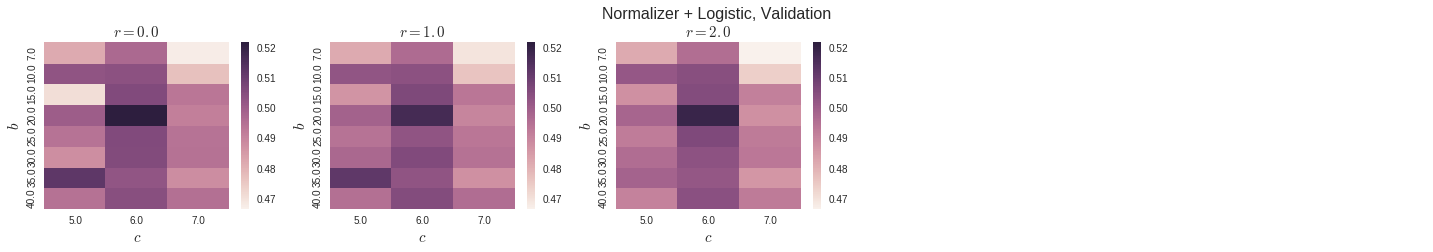

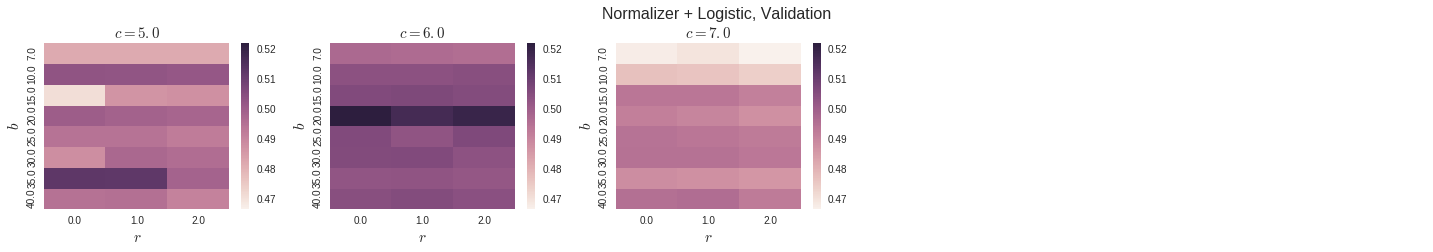

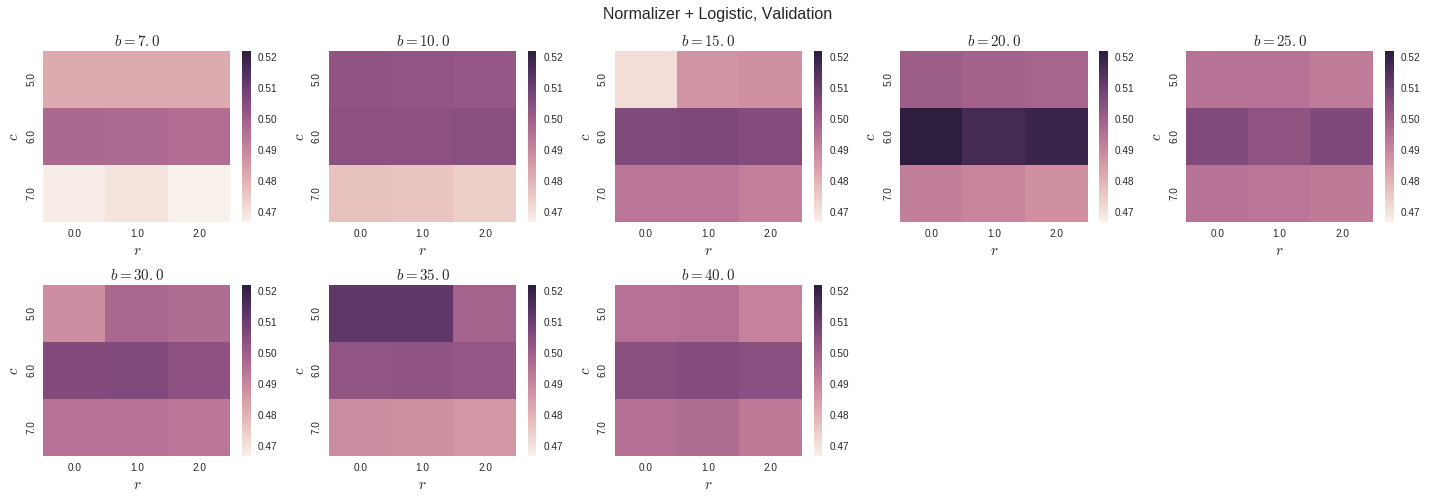

The best:
*allatom-s0-b20-c6-r0--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    115.257    115.827      105.549      105.571   
Top 1                    0.0353982  0.0353982    0.0265487    0.0265487   
Top 5                    0.0752212  0.0619469    0.0663717    0.0707965   
Mean score for top 1       7.33724   0.584623     0.485977     0.522198   
Mean loss score           -4.71064   0.127982     0.123311     0.117979   
Mean Pearson              0.308967  -0.279186    -0.297289    -0.296327   
Mean Spearman             0.258395  -0.201937    -0.227425    -0.223642   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      102.248         235.77            90.5575   
Top 1                       0.039823              0          0.0575221   
Top 5                      0.0752212              0           0.119469   
Mean score for top 1        0.380057        7.33724            0.61401   
Mean loss score            0.0963655        56.4978           0.140299   
Mean Pearson               -0.311195       0.308967          -0.331845   
Mean Spearman              -0.241324       0.258414          -0.282456   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                100.611                99.4071   
Top 1                                0.0442478               0.039823   
Top 5                                0.0973451               0.106195   
Mean score for top 1                  0.520156               0.560831   
Mean loss score                        0.21265               0.198019   
Mean Pearson                         -0.323911              -0.331512   
Mean Spearman                        -0.286016              -0.295586   

                        GDT-HA-score-backwards  
Mean rank of the native                101.956  
Top 1                                0.0442478  
Top 5                                  0.10177  
Mean score for top 1                  0.409304  
Mean loss score                        0.19405  
Mean Pearson                         -0.329919  
Mean Spearman                        -0.295671

In [16]:
plot_results(results_val,
             'Normalizer + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

plot_results(results_val,
             'Normalizer + Logistic', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

#### Feature normalization

##### Mean score for top 1

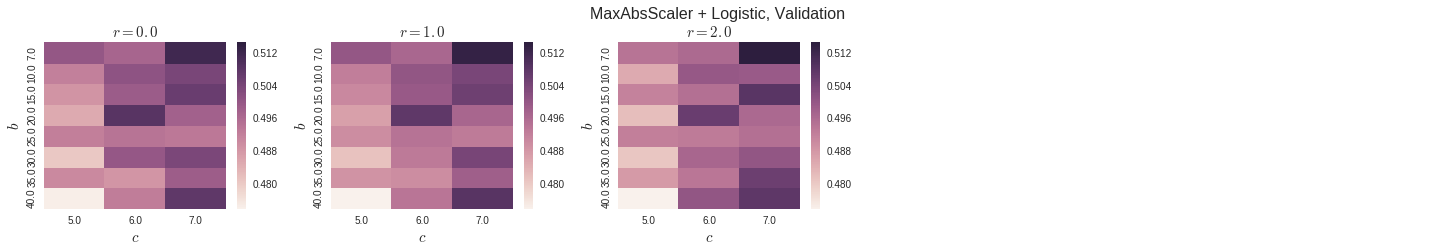

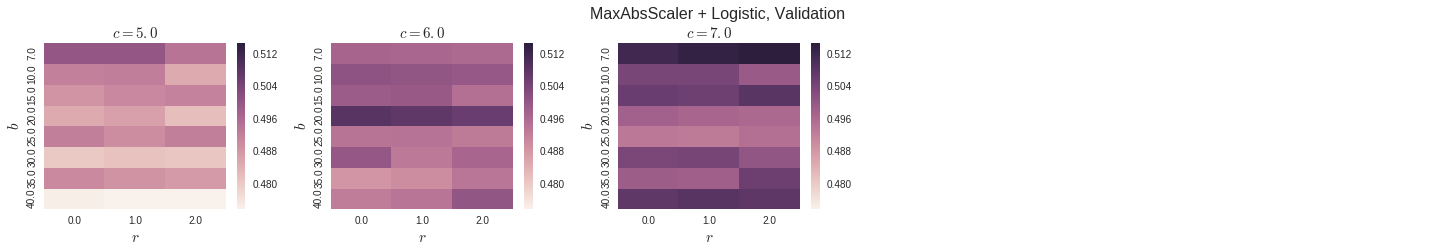

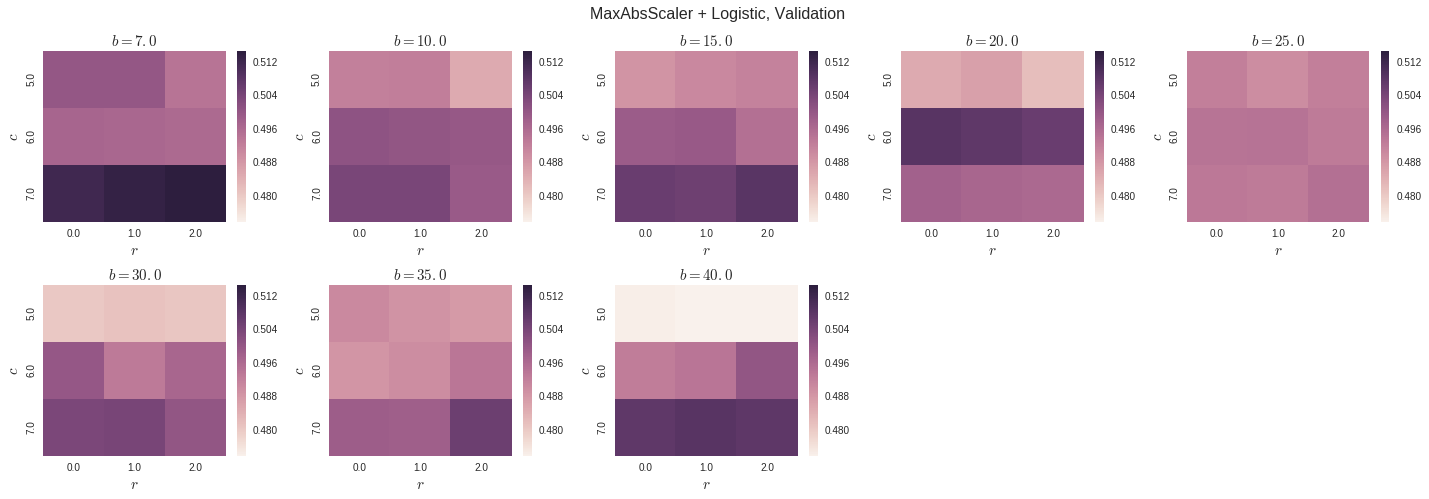

The best:
*allatom-s0-b7-c7-r2--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     88.4602    131.854      123.925      123.142   
Top 1                    0.00884956  0.0132743    0.0132743    0.0176991   
Top 5                     0.0265487  0.0442478    0.0530973    0.0663717   
Mean score for top 1        9.27988   0.586716     0.473781     0.514889   
Mean loss score            -6.65329   0.125889     0.135508     0.125288   
Mean Pearson               0.201764  -0.132535    -0.174992    -0.161754   
Mean Spearman              0.222453 -0.0707634    -0.127729    -0.107857   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      119.881        190.301            82.7345   
Top 1                      0.0176991              0         0.00442478   
Top 5                      0.0752212              0          0.0442478   
Mean score for top 1        0.368001        9.27988           0.570732   
Mean loss score             0.108421        54.5552           0.183577   
Mean Pearson               -0.187074       0.201764          -0.224358   
Mean Spearman              -0.142245       0.222437          -0.221803   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                74.6903                75.3142   
Top 1                               0.00884956             0.00442478   
Top 5                                0.0486726               0.039823   
Mean score for top 1                  0.457906               0.498269   
Mean loss score                         0.2749               0.260581   
Mean Pearson                         -0.262654              -0.267876   
Mean Spearman                        -0.273145              -0.279853   

                        GDT-HA-score-backwards  
Mean rank of the native                77.5708  
Top 1                               0.00884956  
Top 5                                0.0530973  
Mean score for top 1                  0.355465  
Mean loss score                       0.247888  
Mean Pearson                         -0.276859  
Mean Spearman                        -0.288771

In [17]:
plot_results(results_val,
             'MaxAbsScaler + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

plot_results(results_val,
             'MaxAbsScaler + Logistic', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

### Regression

#### Row normalization

##### Mean score for top 1

plot_results(results_val,
             'Normalizer + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

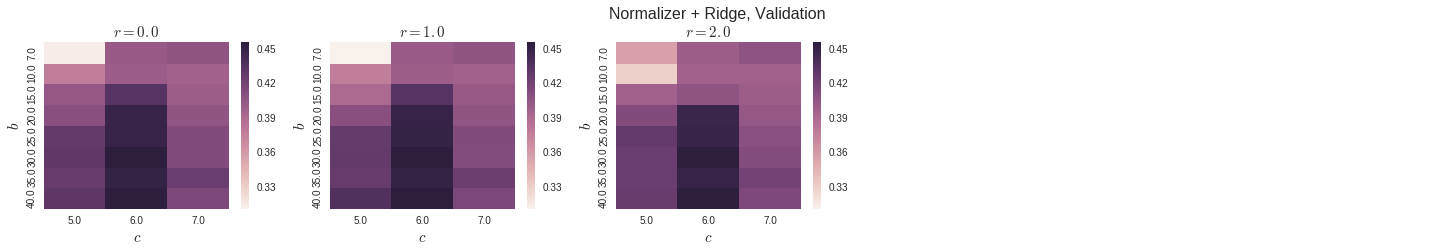

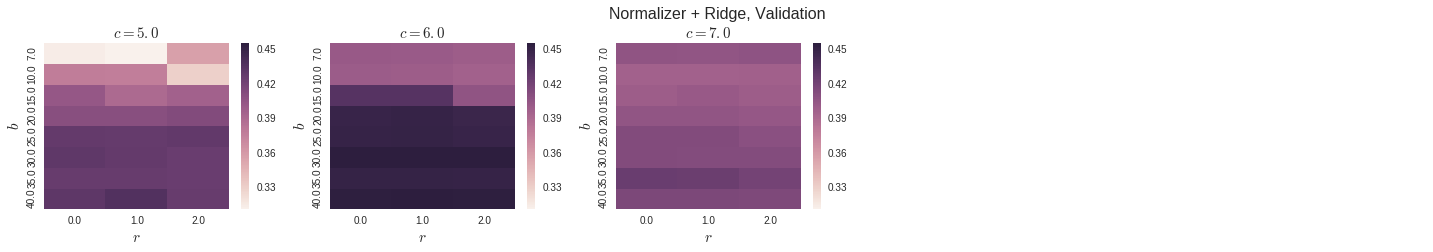

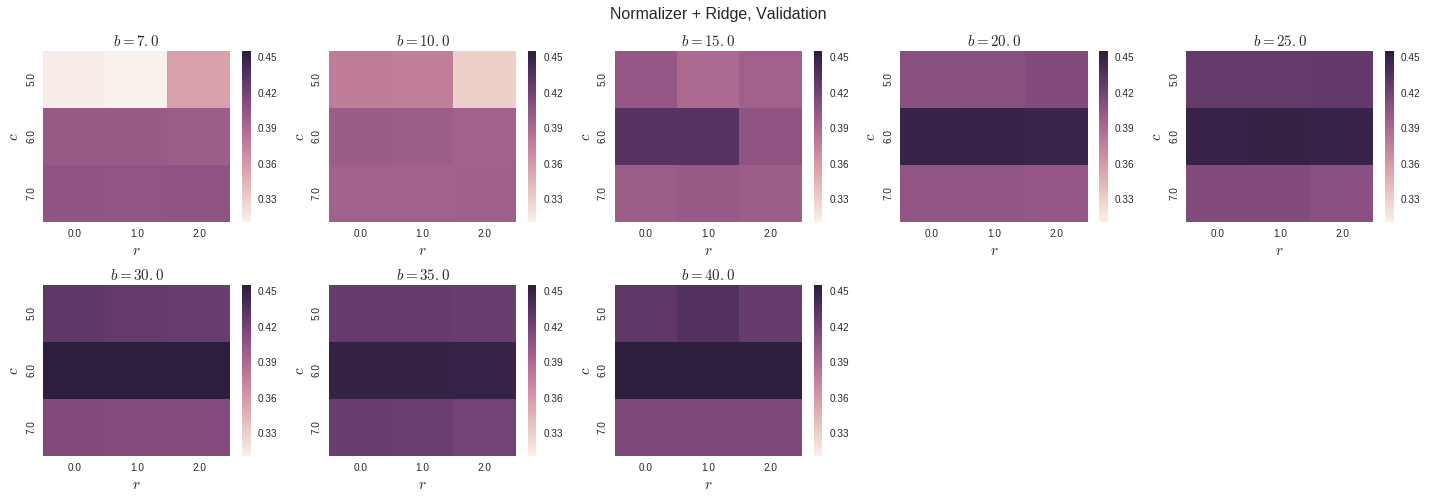

The best:
*allatom-s0-b30-c6-r1--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    122.381     100.664      95.6018      90.7168   
Top 1                    0.0309735  0.00884956            0    0.0132743   
Top 5                     0.079646   0.0353982    0.0221239    0.0353982   
Mean score for top 1       8.25002    0.557931      0.46229     0.495484   
Mean loss score           -5.62342    0.154674     0.146998     0.144693   
Mean Pearson               0.39637   -0.488189    -0.487363    -0.497444   
Mean Spearman             0.354158   -0.401732    -0.405005    -0.415297   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      91.0575        234.854            93.1637   
Top 1                      0.0132743              0          0.0486726   
Top 5                      0.0442478              0           0.106195   
Mean score for top 1        0.359888        8.25002           0.595155   
Mean loss score             0.116535        55.5851           0.159154   
Mean Pearson               -0.499234        0.39637          -0.497514   
Mean Spearman              -0.419702       0.354154          -0.419301   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                112.429                109.973   
Top 1                                0.0309735              0.0353982   
Top 5                                0.0752212               0.079646   
Mean score for top 1                  0.503576               0.540018   
Mean loss score                       0.229231               0.218832   
Mean Pearson                         -0.458146              -0.467672   
Mean Spearman                          -0.3999              -0.410474   

                        GDT-HA-score-backwards  
Mean rank of the native                112.765  
Top 1                                0.0309735  
Top 5                                 0.079646  
Mean score for top 1                  0.393531  
Mean loss score                       0.209823  
Mean Pearson                         -0.454132  
Mean Spearman                        -0.408746

In [18]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

#### Feature normalization

##### Mean score for top 1

plot_results(results_val,
             'MaxAbsScaler + Ridge', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score 

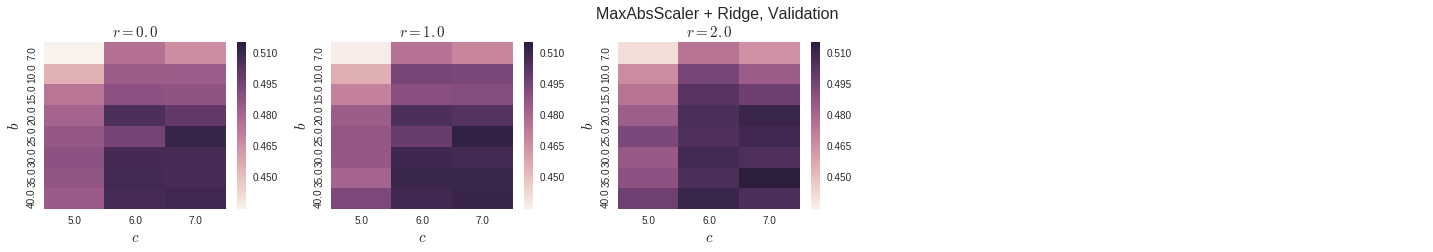

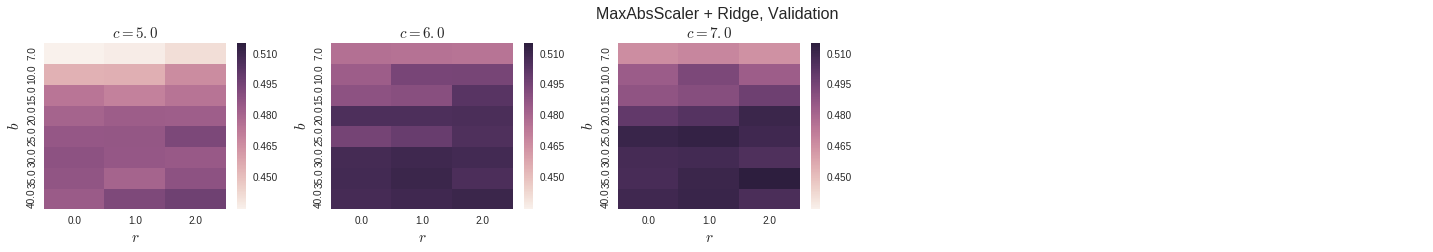

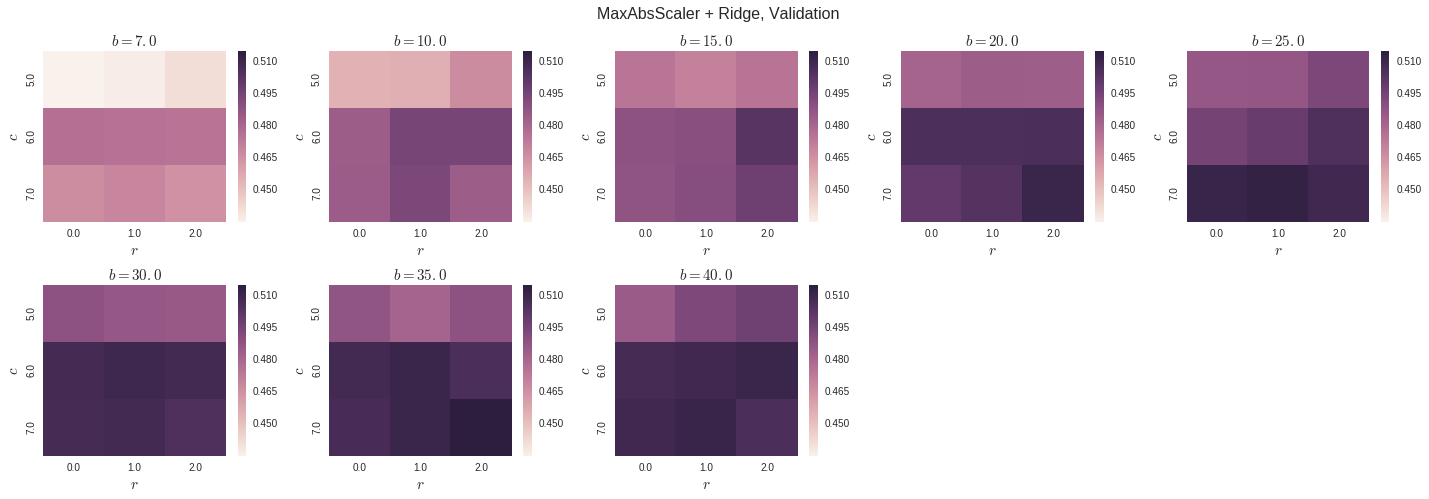

The best:
*allatom-s0-b35-c7-r2--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     143.951    87.4425      85.0575      81.4912   
Top 1                    0.00442478  0.0176991   0.00884956    0.0132743   
Top 5                     0.0176991  0.0575221    0.0619469    0.0619469   
Mean score for top 1        9.16013    0.60379     0.492507      0.53033   
Mean loss score            -6.53353   0.108815     0.116781     0.109847   
Mean Pearson               0.389932  -0.544695    -0.545807    -0.555231   
Mean Spearman              0.340792  -0.469347    -0.461751    -0.475825   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      84.3717        218.009            112.018   
Top 1                      0.0132743              0         0.00442478   
Top 5                       0.079646              0          0.0265487   
Mean score for top 1        0.381316        9.16013           0.576834   
Mean loss score            0.0951062         54.675           0.177475   
Mean Pearson               -0.557029       0.389932          -0.521193   
Mean Spearman              -0.473732       0.340786          -0.424107   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                137.876                134.319   
Top 1                                        0             0.00442478   
Top 5                               0.00884956             0.00884956   
Mean score for top 1                  0.465385                0.50056   
Mean loss score                       0.267422               0.258289   
Mean Pearson                         -0.485336              -0.492879   
Mean Spearman                        -0.401491              -0.407417   

                        GDT-HA-score-backwards  
Mean rank of the native                136.429  
Top 1                               0.00884956  
Top 5                                0.0176991  
Mean score for top 1                  0.359432  
Mean loss score                       0.243922  
Mean Pearson                         -0.479168  
Mean Spearman                        -0.407712

In [19]:
plot_results(results_val,
             'MaxAbsScaler + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

## Backup

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [20]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_allatom.pkl']

### Load from dump

In [10]:
results_train, results_val = joblib.load(theNotebook + '.pkl')